# XYONIX BLOG: Using AI to Predict Influenza, C19 and other Infectious Disease Rates








    
    
    
    
    
        
            
               
                   
                       
                           
                               
                               
    
    

In [1]:
import flu_utils as ut
import os
import pandas as pd
import numpy as np
from glob import glob
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

# data

In [2]:
df = pd.read_csv('data/ILINet.csv', skiprows=1)
display(df.head())
print(df.columns)

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,Alabama,2010,40,X,2.13477,X,X,X,X,X,X,249,35,11664
1,States,Alaska,2010,40,X,0.875146,X,X,X,X,X,X,15,7,1714
2,States,Arizona,2010,40,X,0.674721,X,X,X,X,X,X,172,49,25492
3,States,Arkansas,2010,40,X,0.696056,X,X,X,X,X,X,18,15,2586
4,States,California,2010,40,X,1.95412,X,X,X,X,X,X,632,112,32342


Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS',
       'TOTAL PATIENTS'],
      dtype='object')


In [3]:
column = '%UNWEIGHTED ILI'

weekly_ili = df.groupby(['REGION','YEAR','WEEK'])[column].sum().to_frame()
weekly_ili = weekly_ili[weekly_ili.index.get_level_values('WEEK')!=53]

years = weekly_ili.index.get_level_values('YEAR').values
weeks = weekly_ili.index.get_level_values('WEEK').values

weekly_ili['DATE'] = [date.fromisocalendar(year, week, 1) for year,week in zip(years, weeks)]
weekly_ili['DATE'] = weekly_ili['DATE'].astype('datetime64[ns]')
weekly_ili = weekly_ili.reset_index()[['REGION',column,"DATE"]]
weekly_ili.rename(columns={"REGION":"STATE"}, inplace=True)

weekly_ili[column]=weekly_ili[column].str.replace("X","-999").astype(float).replace(-999, np.nan)

weekly_ili.set_index("DATE", inplace=True)

display(weekly_ili)

,STATE,%UNWEIGHTED ILI
DATE,,
2010-10-04,Alabama,2.13477
2010-10-11,Alabama,2.05999
2010-10-18,Alabama,1.94224
2010-10-25,Alabama,2.27650
2010-11-01,Alabama,2.83371
...,...,...
2020-02-17,Wyoming,4.32494
2020-02-24,Wyoming,3.76975
2020-03-02,Wyoming,1.95678


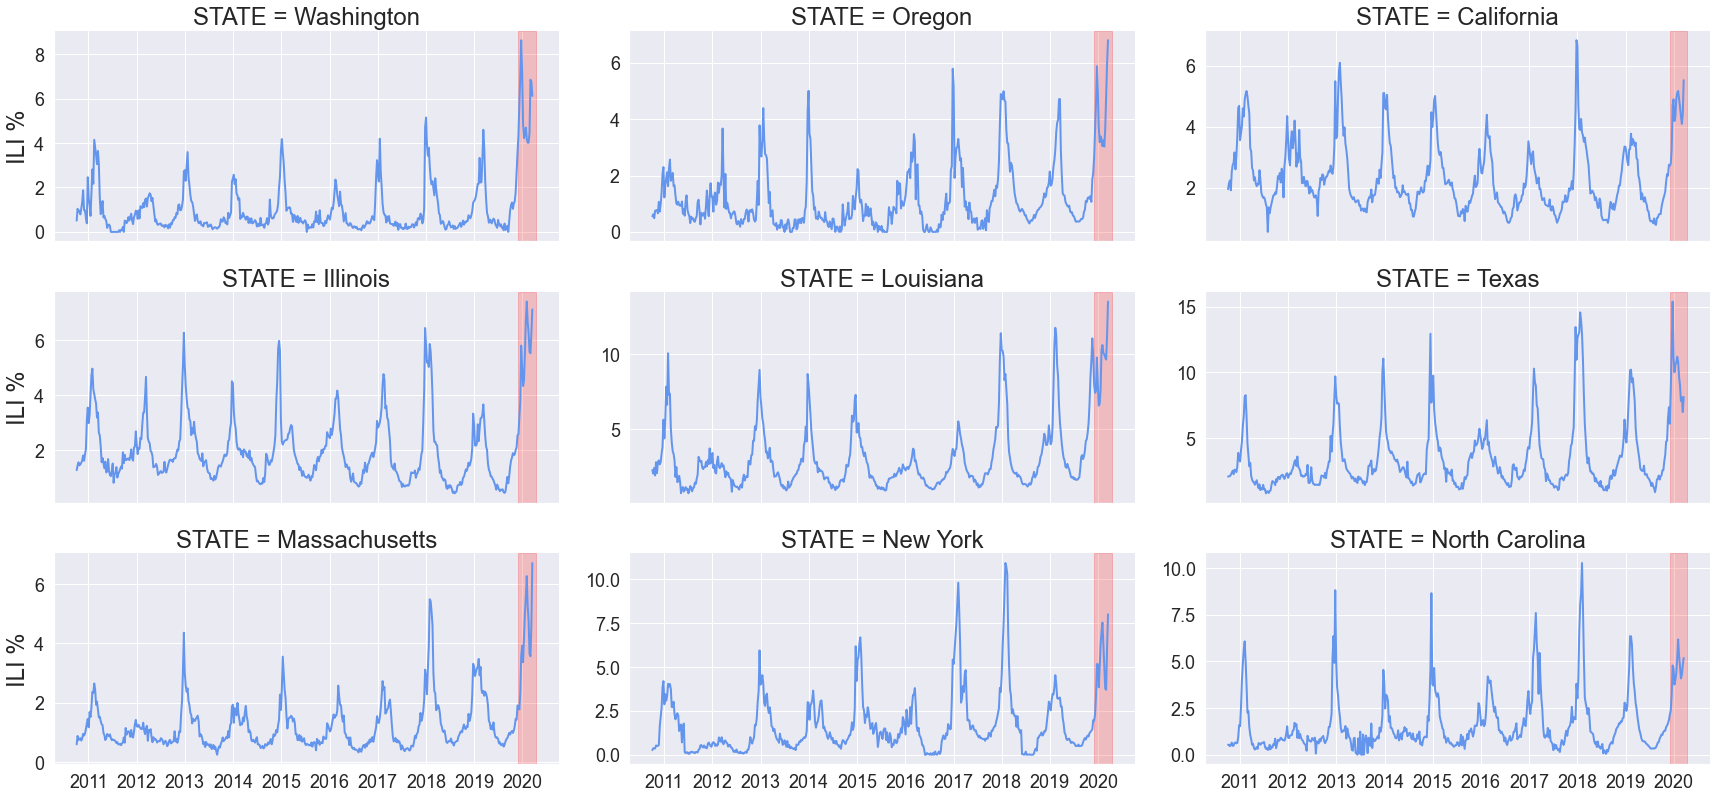

In [4]:
states = ['Washington','Oregon','California',
       'Illinois', 'Louisiana', 'Texas',
       'Massachusetts', 'New York', 'North Carolina']

ili_data = weekly_ili[weekly_ili.STATE.isin(states)]

plt.rcParams["axes.labelsize"] = 30
sns.set(font_scale=2) 
g = sns.FacetGrid(ili_data, 
                  col="STATE",
                  col_order=states,
                  col_wrap=3,
                  height=4, aspect=2, sharey=False)
gg = g.map(ut.ili_plot, column).set_ylabels('ILI %').set_xlabels('')

Text(2015-04-13 00:00:00, 10.4, ' horizon')

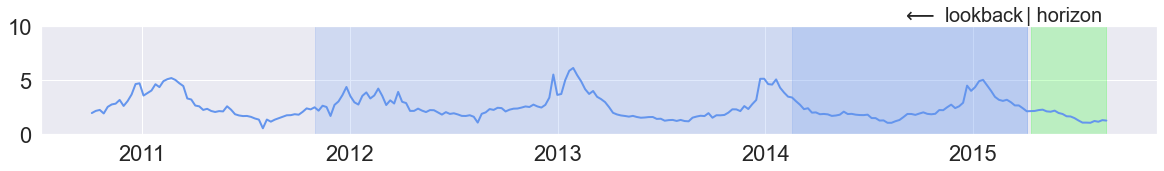

In [5]:
horizon = 20
lookback1 = 60
lookback2 = 180

covid_19_onset='2019-11-01'
no_covid = ili_data.loc['2000-01-01':covid_19_onset]

test_sample = ili_data.loc['2000-01-01':'2015-08-26']
cali = test_sample[test_sample.STATE == 'California']['%UNWEIGHTED ILI']

cali_horizon = cali[-horizon:]
cali_lookback1 = cali[-horizon-lookback1:-horizon]
cali_lookback2 = cali[-horizon-lookback2:-horizon]

fig = plt.figure(figsize=(20, 2))
plt.plot(cali, linewidth=2, color='cornflowerblue')
ax = plt.gca() 
color='cornflowerblue'
ax.set_ylim(0,10)
ytext=10.4
fontsize=20
ax.axvspan(cali_horizon.index.min(), cali_horizon.index.max(), alpha=0.2, color='lime')
ax.axvspan(cali_lookback1.index.min(), cali_lookback1.index.max(), alpha=0.2, color=color)
ax.axvspan(cali_lookback2.index.min(), cali_lookback2.index.max(), alpha=0.2, color=color)
ax.text(cali_horizon.index.min(), ytext, '|', horizontalalignment='right', fontsize=fontsize)
ax.text(cali_horizon.index.min(), ytext, r'$\longleftarrow$ lookback  ', horizontalalignment='right', fontsize=fontsize)
ax.text(cali_horizon.index.min(), ytext, ' horizon', horizontalalignment='left', fontsize=fontsize)

# n-beats state models

In [6]:
report_interval=500
num_training_intervals=10
overwrite = False
horizon=12
lookback_list = [horizon*i for i in [3,5,7,10,12,15]]
state_list = ili_data.STATE.unique().tolist()

In [8]:
for lookback in lookback_list:
    
    for state in state_list:

        print('\n' + ':' * 40 + f' {state} ' + ':' * 40 + '\n')
  
        model_dir = ut.state_model_path(state=state, lookback=lookback, horizon=horizon)
        
        print(f'\nmodel path: {model_dir}\n')
        model_file = os.path.join(model_dir, f'{state}_inference.npz')
        fig_file = os.path.join(model_dir, f'{state}_inference_error.png')
        
        model_saved = os.path.exists(model_file)

        if not model_saved or (model_saved and overwrite):

            # train and score model
            y_test, y_pred, checkpoint = ut.train_and_score_model(state, ili_data, 
                                                                  horizon=horizon,
                                                                  lookback=lookback,
                                                                  report_interval=report_interval,
                                                                  num_training_intervals=num_training_intervals,
                                                                  model_dir=model_dir)
 
            # save model inference
            np.savez(model_file, y_test=y_test, y_pred=y_pred)

            # save plot
            ut.plot_error_histogram(y_test, y_pred, title=state, fig_path=fig_file)

        elif model_saved:

            print(f'Model has been previously saved at {model_dir}. Use "overwrite=True" to overwrite.')




:::::::::::::::::::::::::::::::::::::::: California ::::::::::::::::::::::::::::::::::::::::


model path: saved_models/horizon_12/lookback_36/California

Model has been previously saved at saved_models/horizon_12/lookback_36/California. Use "overwrite=True" to overwrite.

:::::::::::::::::::::::::::::::::::::::: Illinois ::::::::::::::::::::::::::::::::::::::::


model path: saved_models/horizon_12/lookback_36/Illinois

Model has been previously saved at saved_models/horizon_12/lookback_36/Illinois. Use "overwrite=True" to overwrite.

:::::::::::::::::::::::::::::::::::::::: Louisiana ::::::::::::::::::::::::::::::::::::::::


model path: saved_models/horizon_12/lookback_36/Louisiana

Model has been previously saved at saved_models/horizon_12/lookback_36/Louisiana. Use "overwrite=True" to overwrite.

:::::::::::::::::::::::::::::::::::::::: Massachusetts ::::::::::::::::::::::::::::::::::::::::


model path: saved_models/horizon_12/lookback_36/Massachusetts

Model has been previously

# efficacy assessment

In [10]:
state_efficacy = []

for lookback in lookback_list:

    for state in state_list:

        y_true, y_pred = ut.load_inference_data(state=state, lookback=lookback, horizon=horizon)
        mae, mse, smape = ut.efficacy_metrics(y_true, y_pred)
        state_efficacy.append((horizon, lookback, state, mae, mse, smape))
    
state_efficacy_df = pd.DataFrame(data=state_efficacy, columns=['horizon','lookback','STATE','MAE','MSE','sMAPE'])
state_efficacy_df['state'] = [ut.US_STATE_ABBREVIATIONS[s] for s in state_efficacy_df.STATE]

state_efficacy_df.head()

,horizon,lookback,STATE,MAE,MSE,sMAPE,state
0,12,36,California,0.410493,0.379622,0.192897,CA
1,12,36,Illinois,0.752143,1.089963,0.416296,IL
2,12,36,Louisiana,1.218280,3.758675,0.330149,LA
3,12,36,Massachusetts,0.489095,0.693417,0.324820,MA
4,12,36,New York,0.930587,2.437109,0.582531,NY


(0.0, 1.0)

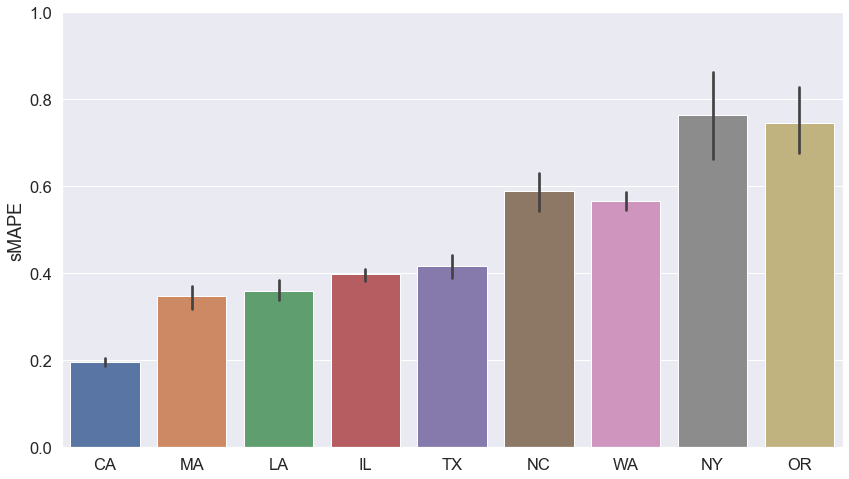

In [11]:
fig=plt.figure(figsize=(14,8))
sns.set(font_scale=1.5) 
sns.barplot(x='state', y='sMAPE', data=state_efficacy_df[['state','sMAPE']].sort_values(['sMAPE']))
ax=fig.gca()
ax.set_xlabel('')
ax.set_ylim(0,1)

<Figure size 432x288 with 0 Axes>

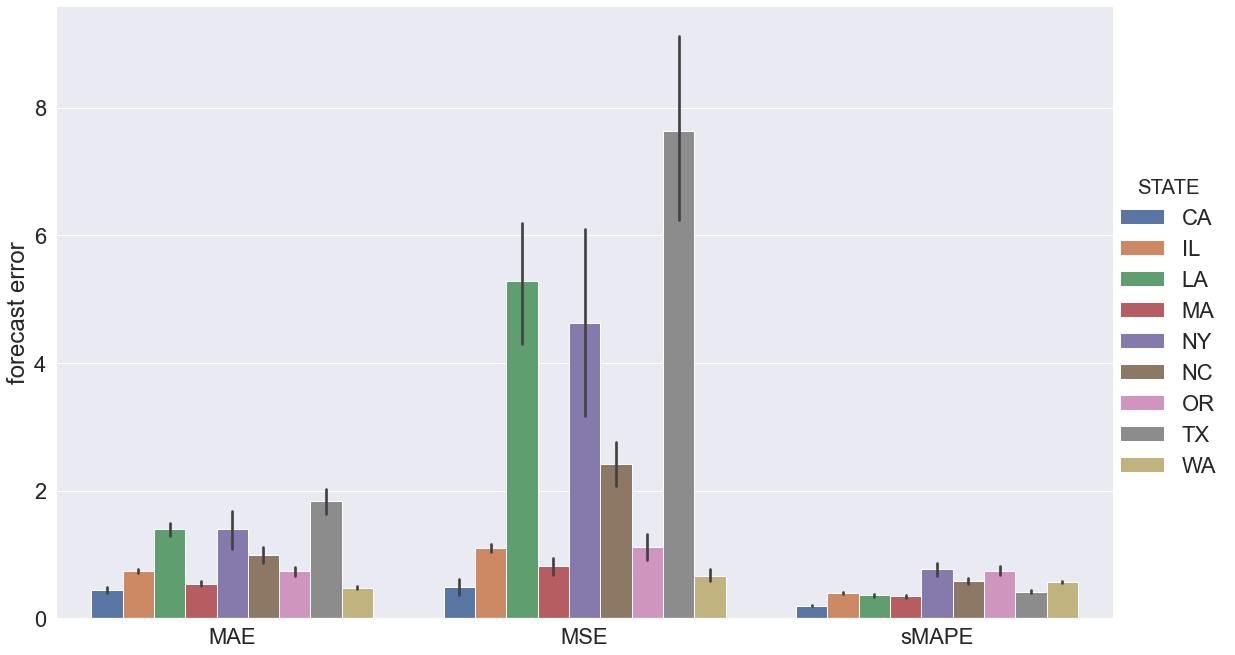

In [13]:
state_efficacy_melted_df = state_efficacy_df.melt(id_vars='state', 
                                                  value_vars=['MAE','MSE','sMAPE'], 
                                                  var_name='metric', 
                                                  value_name='error')

fig = plt.figure()
sns.set(font_scale=2) 
g = sns.catplot(x='metric', y='error', hue = 'state', 
            data=state_efficacy_melted_df, kind='bar',
            height=10, aspect=1.6)

legend = g._legend
legend.set_title('STATE')
ax=plt.gca()
ax.set_xlabel('')
ax.set_ylabel('forecast error')
ax.set_ylim()
plt.show()

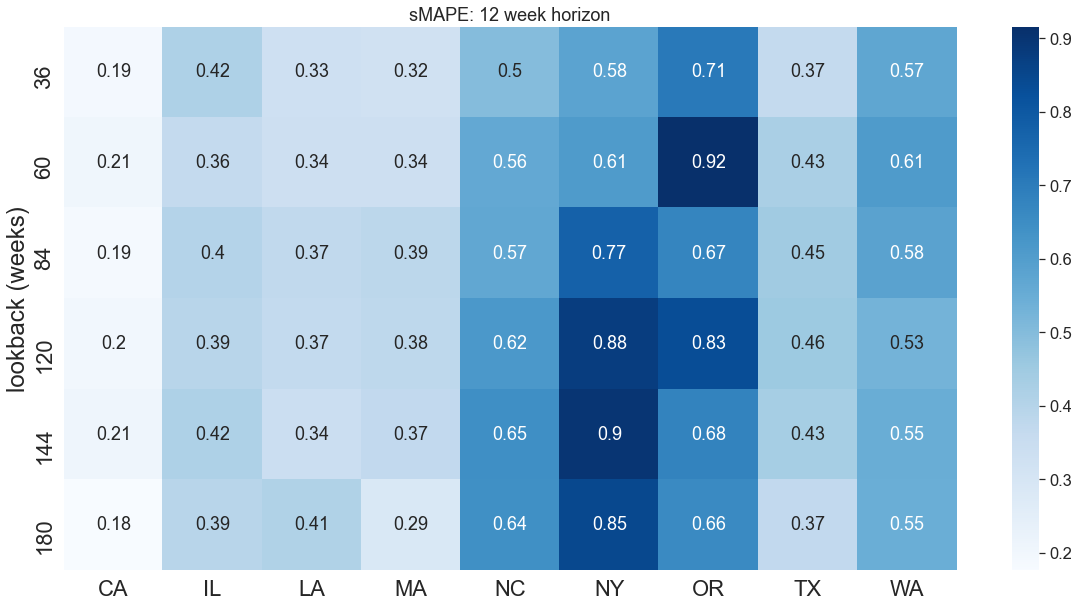

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set(font_scale=1.5) 
state_efficacy_pivot_df = state_efficacy_df.pivot(index='lookback', columns='state', values='sMAPE')
sns.heatmap(state_efficacy_pivot_df, annot=True, fmt=".2g", cmap="Blues", ax=ax)
ax.set_title('sMAPE: 12 week horizon')
ax.set_xlabel('')
_=ax.set_ylabel('lookback (weeks)')

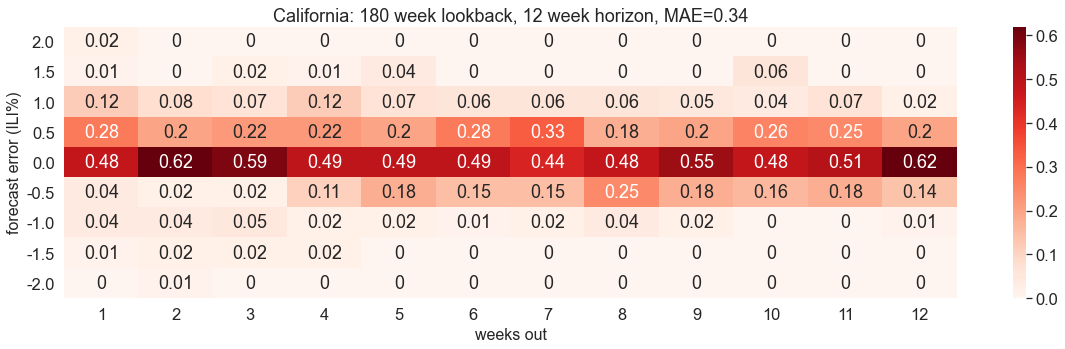

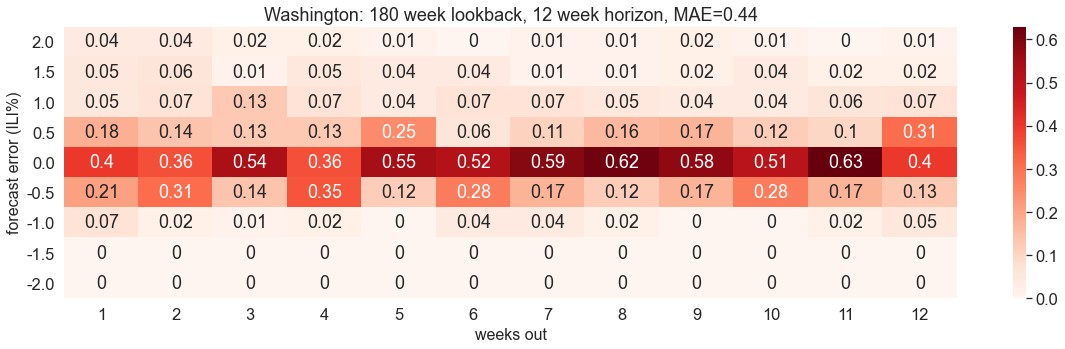

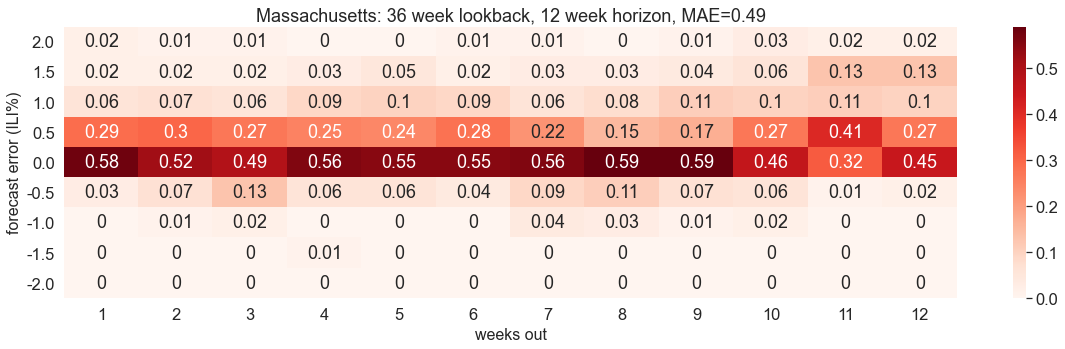

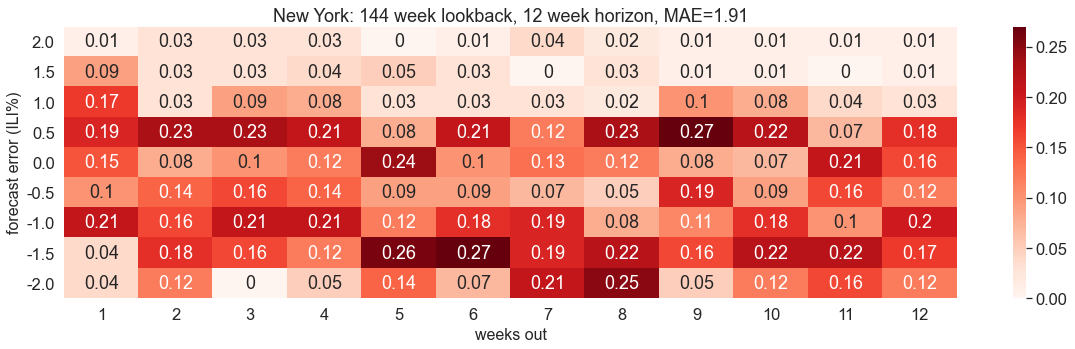

In [16]:
mae_lookup = state_efficacy_df[['STATE','MAE','lookback']].set_index(['STATE','lookback'])

def plot_heatmap(state, lookback, horizon=12, cmap='Reds', title=None):
    y_test, y_pred = ut.load_inference_data(state, lookback, horizon=horizon)
    mae = round(mae_lookup.loc[state, lookback][0],2)
    if title is None:
        title = f'{state}: {lookback} week lookback, {horizon} week horizon, MAE={mae}'
    ut.plot_error_histogram(y_test, y_pred, title=title, y_axis_label='forecast error (ILI%)',
                           cmap=cmap)    
    
plot_heatmap(state='California', lookback=180)
plot_heatmap(state='Washington', lookback=180)
plot_heatmap(state='Massachusetts', lookback=36)
plot_heatmap(state='New York', lookback=144)